In [ ]:
!pip install geopandas

In [ ]:
#Importing needed libraries
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy import stats

In [ ]:
#Loading the dataset
evictions = pd.read_csv('Evictions.csv')
evictions.head()

,COURT_INDEX_NUMBER,DOCKET_NUMBER,EVICTION_ADDRESS,EVICTION_APT_NUM,EXECUTED_DATE,MARSHAL_FIRST_NAME,MARSHAL_LAST_NAME,RESIDENTIAL_COMMERCIAL_IND,BOROUGH,EVICTION_ZIP
0,87935/17,84613,1072 DEAN ST.,2ND FL,08/08/2018,Henry,Daley,Residential,BROOKLYN,11216
1,Q050645/17,379502,228-70 MENTONE AVENUE (ENTIRE HSE),ENT-,05/19/2017,Richard,McCoy,Residential,QUEENS,11413
2,63384/17,72133,683 JEFFERSON AVENUE,4A,08/01/2017,Henry,Daley,Residential,BROOKLYN,11221
3,58199/2015,18932,41-60 MAIN STREET,208B,10/11/2018,Charles,Marchisotto,Residential,QUEENS,11355
4,76525/16,8229,117-18 107TH AVENUE,NaN,05/22/2017,Edward,Guida,Residential,QUEENS,11419


In [ ]:
evictions_residential = evictions[evictions['RESIDENTIAL_COMMERCIAL_IND'] == 'Residential']
evictions_commercial = evictions[evictions['RESIDENTIAL_COMMERCIAL_IND'] == 'Commercial']

In [ ]:
evictions_residential_risk = evictions_residential[['EVICTION_ZIP','RESIDENTIAL_COMMERCIAL_IND']].groupby(['EVICTION_ZIP']).agg('count')
evictions_residential_risk = evictions_residential_risk.rename(columns={'RESIDENTIAL_COMMERCIAL_IND':'counts'})
evictions_residential_risk.head()

,counts
EVICTION_ZIP,
0,3
10000,1
10001,150
10002,242
10003,104


In [ ]:
evictions_commercial_risk = evictions_commercial[['EVICTION_ZIP','RESIDENTIAL_COMMERCIAL_IND']].groupby(['EVICTION_ZIP']).agg('count')
evictions_commercial_risk = evictions_commercial_risk.rename(columns={'RESIDENTIAL_COMMERCIAL_IND':'counts'})
evictions_commercial_risk.head()

,counts
EVICTION_ZIP,
1000,1
10001,196
10002,79
10003,55
10004,10


In [ ]:
evictions_residential_risk['pctl_score'] = evictions_residential_risk.counts.apply(lambda x: stats.percentileofscore(evictions_residential_risk.counts.sort_values(),x))

In [ ]:
evictions_commercial_risk['pctl_score'] = evictions_commercial_risk.counts.apply(lambda x: stats.percentileofscore(evictions_commercial_risk.counts.sort_values(),x))

In [ ]:
ny_shape_file = gpd.read_file('MODZCTA_2010.shp')
geo_conversions = pd.read_csv('/content/ZCTA-to-MODZCTA.csv')
ny_shape_file['MODZCTA'] = ny_shape_file['MODZCTA'].astype(int)
geo_conversions['MODZCTA'] = geo_conversions['MODZCTA'].astype(int)
ny_shape_file = ny_shape_file.merge(geo_conversions,on='MODZCTA',how='left')
ny_shape_file.head()

,MODZCTA,label,geometry,ZCTA
0,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",10001
1,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",10119
2,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",10199
3,10002,10002,"POLYGON ((985342.000 197658.000, 985336.000 19...",10002
4,10003,10003,"POLYGON ((987412.000 202684.000, 987400.000 20...",10003


In [ ]:
ny_shape_file = ny_shape_file.merge(evictions_residential_risk,left_on='ZCTA',right_on='EVICTION_ZIP',how='left')
ny_shape_file = ny_shape_file.rename(columns={'pctl_score':'residential_pctl_score','counts':'residential_counts'})
ny_shape_file.head()

,MODZCTA,label,geometry,ZCTA,residential_counts,residential_pctl_score
0,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",10001,150.0,46.859903
1,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",10119,NaN,NaN
2,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",10199,NaN,NaN
3,10002,10002,"POLYGON ((985342.000 197658.000, 985336.000 19...",10002,242.0,60.869565
4,10003,10003,"POLYGON ((987412.000 202684.000, 987400.000 20...",10003,104.0,37.922705


In [ ]:
ny_shape_file = ny_shape_file.merge(evictions_commercial_risk,left_on='ZCTA',right_on='EVICTION_ZIP',how='left')
ny_shape_file = ny_shape_file.rename(columns={'pctl_score':'commercial_pctl_score','counts':'commercial_counts'})
ny_shape_file.head()

,MODZCTA,label,geometry,ZCTA,residential_counts,residential_pctl_score,commercial_counts,commercial_pctl_score
0,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",10001,150.0,46.859903,196.0,100.000000
1,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",10119,NaN,NaN,NaN,NaN
2,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",10199,NaN,NaN,NaN,NaN
3,10002,10002,"POLYGON ((985342.000 197658.000, 985336.000 19...",10002,242.0,60.869565,79.0,95.384615
4,10003,10003,"POLYGON ((987412.000 202684.000, 987400.000 20...",10003,104.0,37.922705,55.0,86.666667


In [ ]:
ny_shape_file['total_pctl_score'] = (ny_shape_file['residential_pctl_score']+ny_shape_file['commercial_pctl_score'])/2
ny_shape_file['total_counts'] = ny_shape_file['residential_counts']+ny_shape_file['commercial_counts']
ny_shape_file.head()

,MODZCTA,label,geometry,ZCTA,residential_counts,residential_pctl_score,commercial_counts,commercial_pctl_score,total_pctl_score,total_counts
0,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",10001,150.0,46.859903,196.0,100.000000,73.429952,346.0
1,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",10119,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",10199,NaN,NaN,NaN,NaN,NaN,NaN
3,10002,10002,"POLYGON ((985342.000 197658.000, 985336.000 19...",10002,242.0,60.869565,79.0,95.384615,78.127090,321.0
4,10003,10003,"POLYGON ((987412.000 202684.000, 987400.000 20...",10003,104.0,37.922705,55.0,86.666667,62.294686,159.0


/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:568: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:568: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:568: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:568: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:568: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:568: FutureWarning: 'axes' is deprecated, please use 'ax' instead (fo

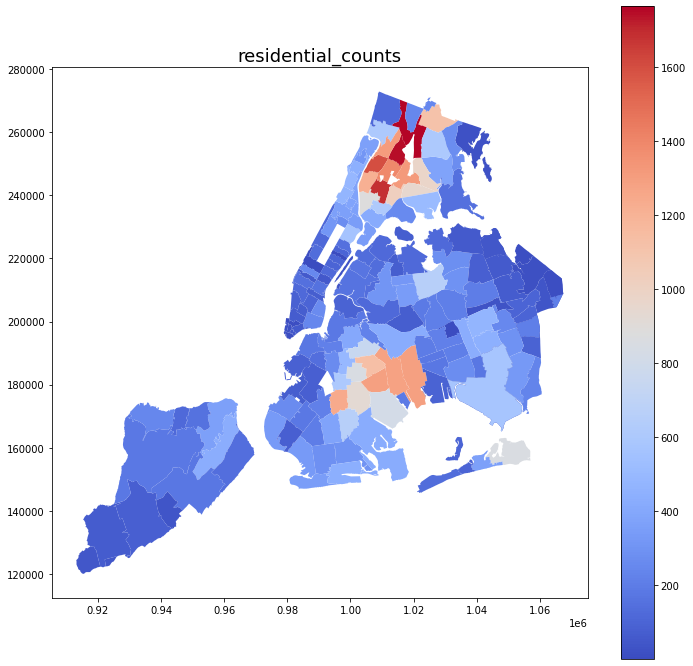

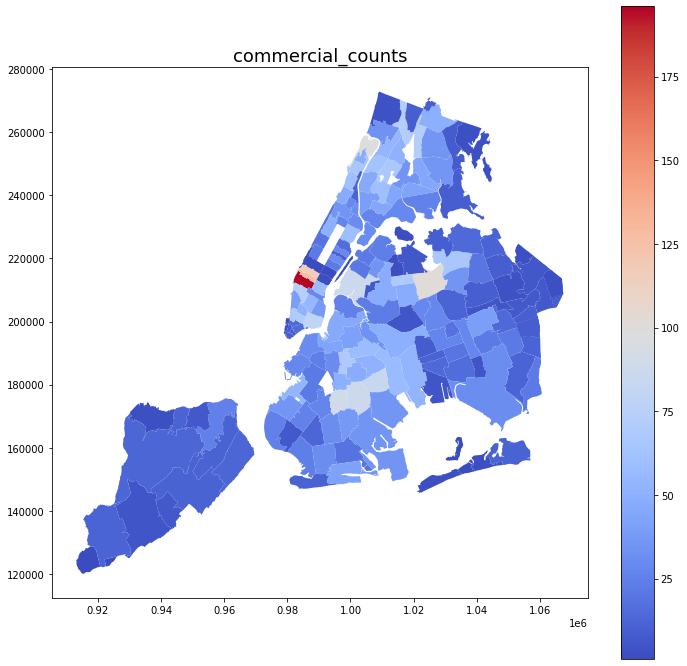

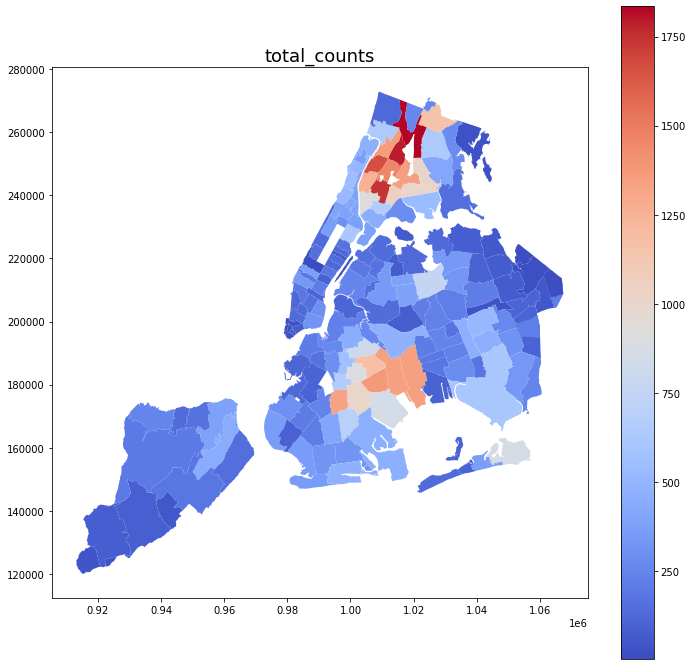

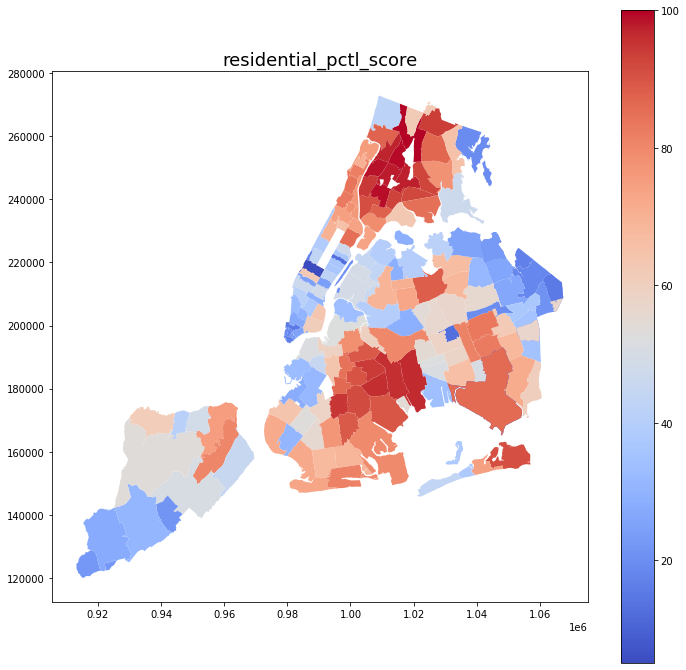

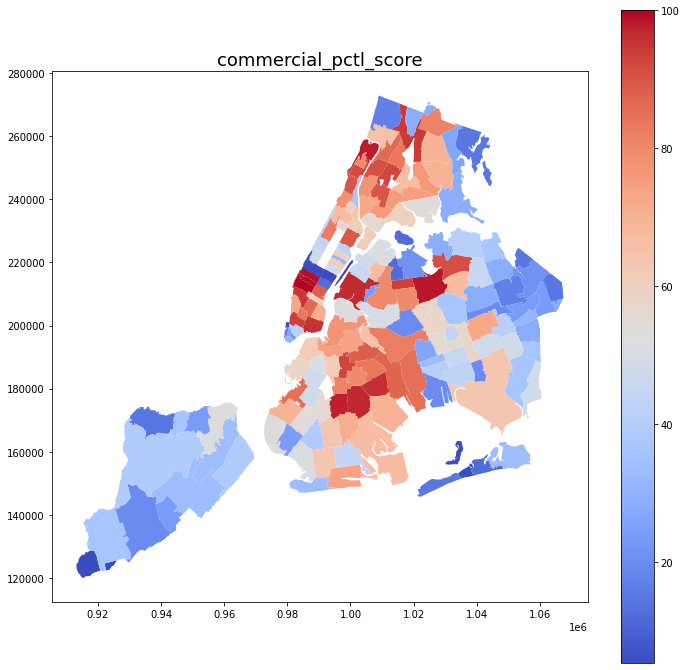

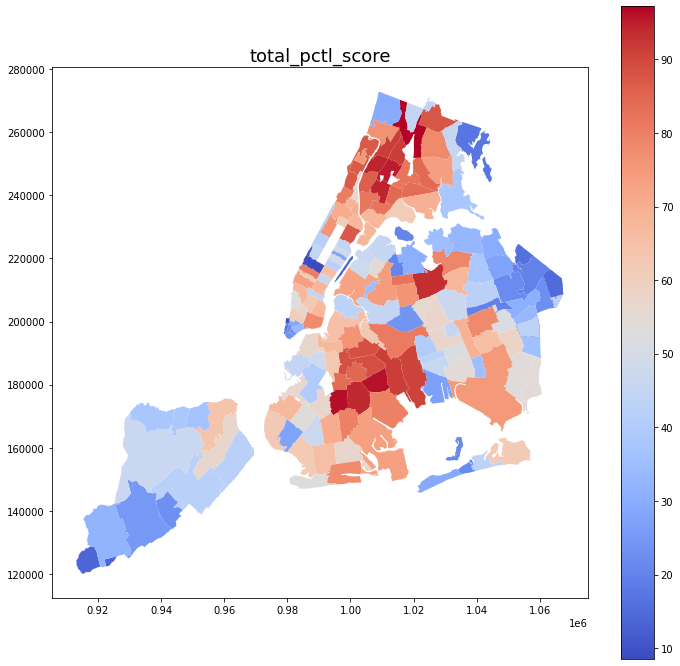

In [ ]:
import matplotlib.pyplot as plt


hos_cols = ['residential_counts','commercial_counts','total_counts','residential_pctl_score','commercial_pctl_score','total_pctl_score']


for i in hos_cols:
  f, ax = plt.subplots(1, figsize=(12, 12))

  ax.set_title(i, fontsize=18)
  ny_shape_file.plot(axes=ax, column=i, legend = True, cmap='coolwarm')

In [ ]:
ny_shape_file.to_csv('evictions_results.csv')